In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch
import torch.nn.functional as F
import math
from collections import defaultdict

In [2]:
from ale_py import ALEInterface
ale = ALEInterface()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [3]:
from ale_py.roms import Skiing
ale.loadROM(Skiing)

Game console created:
  ROM file:  /home/makinoharafan1/code/rl-atari-skiing/rl-skiing/lib/python3.11/site-packages/AutoROM/roms/skiing.bin
  Cart Name: Skiing (1980) (Activision) [!]
  Cart MD5:  b76fbadc8ffb1f83e2ca08b6fb4d6c9f
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1715520522


In [4]:
from typing import Any, Text

from ale_py.env import gym as ale_gym

# Patch to allow rendering Atari games.
# The AtariEnv's render method expects the mode to be in self._render_mode
# (usually initialized with env.make) instead of taking mode as a param.
_original_atari_render = ale_gym.AtariEnv.render


def atari_render(self, mode: Text = 'rgb_array') -> Any:
  original_render_mode = self._render_mode
  try:
    self._render_mode = mode
    return _original_atari_render(self)
  finally:
    self._render_mode = original_render_mode


ale_gym.AtariEnv.render = atari_render

In [108]:
# env = gym.make('ALE/Skiing-v5', render_mode='human')
env = gym.make('ALE/Skiing-v5', render_mode='rgb_array')

In [109]:
from gymnasium.wrappers import RecordVideo

trigger = lambda t: t % 1000 == 0

env = RecordVideo(env, video_folder="./videos_sarsa", episode_trigger=trigger, disable_logger=True)

In [6]:
def epsilon_greedy_policy(state, Q, epsilon, n_action):
  probs = torch.ones(n_action) * epsilon / n_action
  best_action = torch.argmax(Q[state]).item()
  probs[best_action] += 1.0 - epsilon
  return torch.multinomial(probs, 1).item()

# def epsilon_greedy_policy(state, Q, epsilon, n_action):
#     if torch.rand(1).item() < epsilon:
#         return torch.randint(0, n_action, (1,)).item()
#     else:
#         return torch.argmax(Q[state]).item()

In [7]:
def softmax_policy(state, Q, temperature):
    logits = Q[state] / temperature
    action_probs = F.softmax(logits, dim=0)
    action = torch.multinomial(action_probs, 1).item()
    return action

In [8]:
def get_pos_player(observe):
    ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
    if len(ids[0]) == 0:
        return 0, 0  
    else:
        return int(ids[0].mean()), int(ids[1].mean())

In [9]:
def get_pos_flags(observe):
    if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
        ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
        return int(ids[0].mean()), int(ids[1].mean())
    else:
        base = 0
        ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
        if len(ids[0]) == 0:
            return 0, 0  
        else:
            return int(ids[0].mean() + base), int(ids[1].mean())

In [10]:
def chebyshev_distance(vec1, vec2): 
      dist = np.max(np.absolute(np.array(vec1) - np.array(vec2)))
      return dist

In [11]:
def manhattan_distance(vec1, vec2):
      dist = sum([np.abs(a - b) for a, b in zip(vec1, vec2)])
      return dist

In [12]:
def euclidian_distance(vec1, vec2):
    dist = math.sqrt((vec1[0] - vec2[0]) ** 2 + (vec1[1] - vec2[1]) ** 2)
    return dist

In [74]:
def calculate_reward(prev_distance, curr_distance):
    if curr_distance < prev_distance:
        return 0
    else:
        return -1

In [110]:
def sarsa(env, gamma, n_episode, alpha, epsilon, temperature=0.1):
  n_action = env.action_space.n
  Q = defaultdict(lambda: torch.zeros(n_action))

  for episode in range(n_episode):
    state = env.reset()
    
    player_pos = get_pos_player(state[0])
    flags_pos = get_pos_flags(state[0])

    distance_frame1 = euclidian_distance(player_pos, flags_pos)
    
    state = flags_pos[1], player_pos[1]
    is_done = False

    # action = softmax_policy(state, Q, temperature)
    action = epsilon_greedy_policy(state, Q, epsilon, n_action)

    while not is_done:
      # distance = - euclidian_distacne(player_pos, flags_pos)
      # distance = - manhattan_distance(player_pos, flags_pos)
      # distance = - chebyshev_distance(player_pos, flags_pos)
      
      new_state, reward, is_done, _, _ = env.step(action)

      player_pos = get_pos_player(new_state)
      flags_pos = get_pos_flags(new_state)

      distance_frame2 = euclidian_distance(player_pos, flags_pos)

      new_reward = calculate_reward(distance_frame1, distance_frame2)

      new_state = flags_pos[1], player_pos[1]

      new_action = epsilon_greedy_policy(new_state, Q, epsilon, n_action)
      # new_action = softmax_policy(new_state, Q, temperature)

      td_target = new_reward + gamma * Q[new_state][new_action]
      td_error = td_target - Q[state][action]
      Q[state][action] += alpha * td_error
      
      length_episode[episode] += 1
      total_reward_episode[episode] += reward

      distance_frame1 = distance_frame2
      state = new_state
      action = new_action
    
    print("Episode:", episode, "Total Reward:", total_reward_episode[episode])

  policy = {}
  for state, actions in Q.items():
    policy[state] = torch.argmax(actions).item()

  return Q, policy

In [111]:
n_episode = 10000

length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

gamma = 0.8
alpha = 0.2
epsilon = 0.05

In [113]:
env.reset()
optimal_Q, optimal_policy = sarsa(env, gamma, n_episode, alpha, epsilon, temperature=0.9)

Episode: 0 Total Reward: -34533.0
Episode: 1 Total Reward: -35324.0
Episode: 2 Total Reward: -34802.0
Episode: 3 Total Reward: -36020.0
Episode: 4 Total Reward: -21472.0
Episode: 5 Total Reward: -16493.0
Episode: 6 Total Reward: -18827.0
Episode: 7 Total Reward: -18321.0
Episode: 8 Total Reward: -17621.0
Episode: 9 Total Reward: -18328.0
Episode: 10 Total Reward: -18024.0
Episode: 11 Total Reward: -19600.0
Episode: 12 Total Reward: -16631.0
Episode: 13 Total Reward: -20835.0
Episode: 14 Total Reward: -16971.0
Episode: 15 Total Reward: -17550.0
Episode: 16 Total Reward: -19461.0
Episode: 17 Total Reward: -14575.0
Episode: 18 Total Reward: -19264.0
Episode: 19 Total Reward: -14906.0
Episode: 20 Total Reward: -17547.0
Episode: 21 Total Reward: -16202.0
Episode: 22 Total Reward: -17629.0
Episode: 23 Total Reward: -12501.0
Episode: 24 Total Reward: -16791.0
Episode: 25 Total Reward: -13494.0
Episode: 26 Total Reward: -15149.0
Episode: 27 Total Reward: -17657.0
Episode: 28 Total Reward: -127

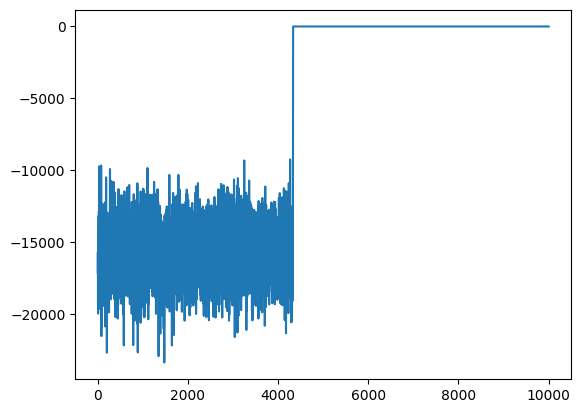

In [80]:
plt.plot(np.arange(1, n_episode + 1), total_reward_episode)
plt.show()

In [29]:
sarsa_w_manhattan = total_reward_episode

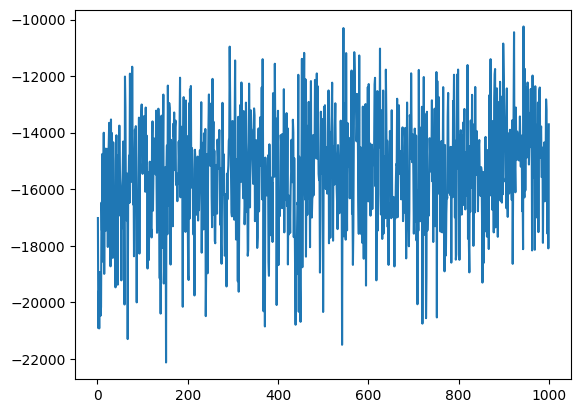

In [48]:
plt.plot(np.arange(1, n_episode + 1), sarsa_w_manhattan)
plt.show()

## Точечная оценка J

In [54]:
mean_reward = np.mean(sarsa_w_manhattan)
mean_reward

-15404.904

## Интервальная оценка J

95.0% Confidence Interval: [-19602.6, -11839.95]


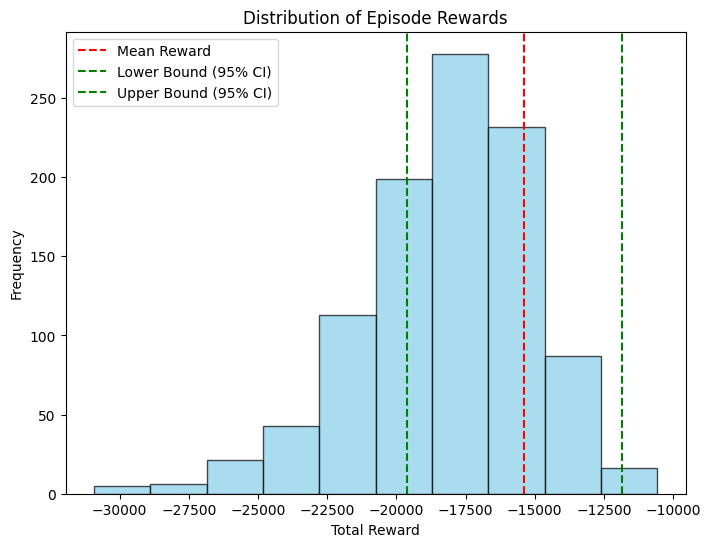

In [55]:
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

lower_bound = np.percentile(sarsa_w_manhattan, lower_percentile)
upper_bound = np.percentile(sarsa_w_manhattan, upper_percentile)

print(f"{confidence_level * 100}% Confidence Interval: [{lower_bound}, {upper_bound}]")

plt.figure(figsize=(8, 6))
plt.hist(total_reward_episode, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=mean_reward, color='red', linestyle='--', label='Mean Reward')
plt.axvline(x=lower_bound, color='green', linestyle='--', label='Lower Bound (95% CI)')
plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound (95% CI)')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Rewards')
plt.legend()
plt.show()